# TASK 5 Compare the similarity between generated data and RA-data

## Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

from sklearn.mixture import GaussianMixture
import pickle

from sklearn.neighbors import KernelDensity

## Import Files

In [2]:
df = pd.read_csv("ModifiedDATA/scaled_ra.csv")

In [6]:
dfs = pd.read_csv("ModifiedDATA/scaled_ra.csv")
G8_patients = np.load("GeneratedDATA/G8_patients.npy", allow_pickle=True)
G36_patients = np.load("GeneratedDATA/G36_patients.npy", allow_pickle=True)

## Helper functions

In [5]:
def get_cells_of_group_without_columns(df, group, columns):
    return df[df.group == group][df.columns.difference(columns)]

def get_cells_of_patient_without_columns(df, id_, columns):
    return df[df.id == id_][df.columns.difference(columns)]

## Density of a person

In [11]:
persons_cells = get_cells_of_patient_without_columns(df, 1,["id","group"])

Text(0.5,1,'-423219.3533031583')

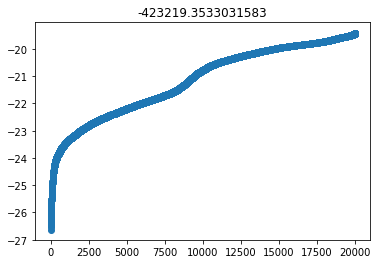

In [43]:
# TODO se if other kernels are more appropriate
k_density_estimator = KernelDensity(kernel = "exponential", bandwidth=0.75).fit(persons_cells)
score = k_density_estimator.score(persons_cells)
sample_score = k_density_estimator.score_samples(persons_cells)
sample_score.sort()
plt.scatter(range(len(sample_score)),sample_score)
plt.title(score)

Text(0.5,1,'-67575.35166079669')

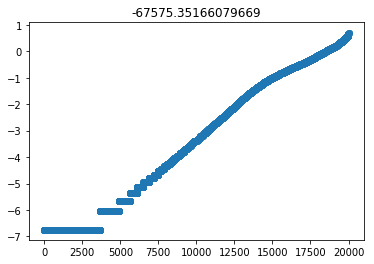

In [44]:
# TODO se if other kernels are more appropriate
k_density_estimator = KernelDensity(kernel = "tophat", bandwidth=0.75).fit(persons_cells)
score = k_density_estimator.score(persons_cells)
sample_score = k_density_estimator.score_samples(persons_cells)
sample_score.sort()
plt.scatter(range(len(sample_score)),sample_score)
plt.title(score)

Text(0.5,1,'-243620.51333875215')

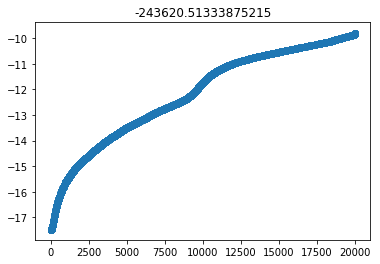

In [45]:
# TODO se if other kernels are more appropriate
k_density_estimator = KernelDensity(kernel = "gaussian", bandwidth=0.75).fit(persons_cells)
score = k_density_estimator.score(persons_cells)
sample_score = k_density_estimator.score_samples(persons_cells)
sample_score.sort()
plt.scatter(range(len(sample_score)),sample_score)
plt.title(score)

Text(0.5,1,'-40139.84396295109')

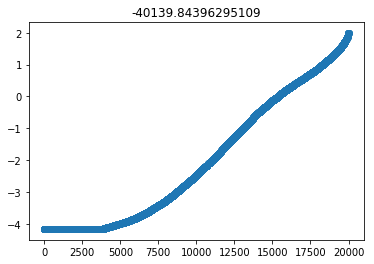

In [47]:
# TODO se if other kernels are more appropriate
k_density_estimator = KernelDensity(kernel = "linear", bandwidth=0.75).fit(persons_cells)
score = k_density_estimator.score(persons_cells)
sample_score = k_density_estimator.score_samples(persons_cells)
sample_score.sort()
plt.scatter(range(len(sample_score)),sample_score)
plt.title(score)

##### Notes: 
- It looks like the linear kernal give closest estimation.

## Difference between two denisties

### Kulback leibler divergence
discrete
$$D_{KL}(P||Q) = \sum_{x\in X} P(x)\log\frac{P(x)}{Q(x)}$$
continues
$$D_{KL}(P||Q) = \int_{x\in X} P(x)\log\frac{P(x)}{Q(x)}$$

It is the amount of information lost when  $Q$ is used to approximate $P$. The smaller the kl divergence, the more similar are the distributions.

In [11]:
def KL(a,b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    a = np.exp(np.where(a!= float('-inf'), a, 0))
    b = np.exp(np.where(b!= float('-inf'), b, 0))
    
    cond = np.logical_and(b != float('-inf'), a!= float('-inf'), b != 0)
    
    return np.sum(np.where(cond, a * np.log(a / b), 0))

- Let X = the combination of one original data and the sampled data.
- Let P(X) = the density of X under the patients density
- Let Q(X) = the density of X under the samples density

#### NOTES: 
- I used the embedded data because the orginal data was difficualt to estimate using kernel density estimator

### KL using embedded data from G8 gmm

In [68]:
def meshgrid(min_value = -15,max_value=15):
    grid_margins = [np.linspace(min_value, max_value, 120)] * 2
    grid = np.stack(np.meshgrid(*grid_margins), -1).reshape(-1, len(grid_margins))
    return grid

In [127]:
def KL_between_two_patients(p1, p2, symmetric=True):
    max_1 = np.max(p1)
    min_1 = np.min(p1)
    max_2 = np.max(p2)
    min_2 = np.min(p2)
    X = meshgrid(min_value = np.min([min_1, min_2])-1, max_value = np.max([max_1,max_2])+1 )
    
    P_k_density_estimator = KernelDensity(kernel = "linear", bandwidth=1).fit(p1)
    P_sample_score = P_k_density_estimator.score_samples(X)
    
    Q_k_density_estimator = KernelDensity(kernel = "linear", bandwidth=1).fit(p2)
    Q_sample_score = Q_k_density_estimator.score_samples(X)
    kl_score = 0
    
    if(symmetric):
        kl_score = KL(P_sample_score, Q_sample_score) + KL(Q_sample_score, P_sample_score)
    else:
        kl_score = KL(P_sample_score, Q_sample_score)
    
    return kl_score

#### Compare 
- control sampled and control original
- diseased sampled and diseased original
- diseased sampled and control original
- control sampled and diseased original

##### Load embeddings

In [98]:
UMAP_ = np.load('UMAP_.npy') 
# umap emdedding of all patient cells where 
# we embed each group separately -> get the embedding each patient separately

##### Sample 20 control and 20 diseased from GMM

In [174]:
sampled_controls = generate_patients(G8s["control"],sample_size=20000, nr_patients=20)
sampled_diseased = generate_patients(G8s["diseased"],sample_size=20000, nr_patients=20)
original_controls = UMAP_[:20]
original_diseased = UMAP_[20:]

##### Embed the samples using UMAP

In [175]:
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)
embedded_sampled_controls = []
embedded_sampled_diseased = []
for i in range(20):
    embedded_sampled_controls.append(up.fit_transform(sampled_controls[i]))
    embedded_sampled_diseased.append(up.fit_transform(sampled_diseased[i]))

##### Get the KL divergence between each pair of sample and original patient

In [310]:
KL_sum_cc_8 = np.empty((20,20))
KL_sum_dd_8 = np.empty((20,20))
KL_sum_cd_8 = np.empty((20,20))
KL_sum_dc_8 = np.empty((20,20))
for i in range(20):
    for j in range(20):# Get the KL divergence between each pair of sample and original patient
        KL_sum_cc_8[i,j] = KL_between_two_patients(embedded_sampled_controls[i], original_controls[j])
        KL_sum_dd_8[i,j] = KL_between_two_patients(embedded_sampled_diseased[i], original_diseased[j])
        KL_sum_cd_8[i,j] = KL_between_two_patients(embedded_sampled_diseased[i], original_controls[j])
        KL_sum_dc_8[i,j] = KL_between_two_patients(embedded_sampled_controls[i], original_diseased[j])

### HeatMap

#### NOTES:
- Concatenated the heapmap to get relative view of how the match

In [70]:
ab = np.concatenate((KL_sum_cc_8,KL_sum_cd_8),axis=1)
cd = np.concatenate((KL_sum_dc_8,KL_sum_dd_8),axis=1)
abcd = np.concatenate((ab,cd),axis=0)

Text(30.5,0.5,'sampled d c')

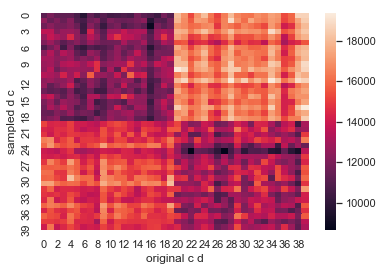

In [71]:
plt.figure(fig_size=(16,16))
sns.set()
ax = sns.heatmap(abcd)
ax.set_xlabel("original c d")
ax.set_ylabel("sampled d c")

### KL using embedded data from G36 gmm

In [213]:
g36_sampled_controls = generate_patients(G36s["control"],sample_size=20000, nr_patients=20)
g36_sampled_diseased = generate_patients(G36s["diseased"],sample_size=20000, nr_patients=20)

In [214]:
up = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)
g36_embedded_sampled_controls = []
g36_embedded_sampled_diseased = []
for i in range(20):
    g36_embedded_sampled_controls.append(up.fit_transform(g36_sampled_controls[i]))
    g36_embedded_sampled_diseased.append(up.fit_transform(g36_sampled_diseased[i]))

##### Get the KL divergence between each pair of sample and original patient

In [313]:
KL_sum_cc_36 = np.empty((20,20))
KL_sum_dd_36 = np.empty((20,20))
KL_sum_cd_36 = np.empty((20,20))
KL_sum_dc_36 = np.empty((20,20))
for i in range(20):
    for j in range(20):
        KL_sum_cc_36[i,j] = KL_between_two_patients(g36_embedded_sampled_controls[i], original_controls[j])
        KL_sum_dd_36[i,j] = KL_between_two_patients(g36_embedded_sampled_diseased[i], original_diseased[j])
        KL_sum_cd_36[i,j] = KL_between_two_patients(g36_embedded_sampled_diseased[i], original_controls[j])
        KL_sum_dc_36[i,j] = KL_between_two_patients(g36_embedded_sampled_controls[i], original_diseased[j])

#### HeatMap

In [318]:
ab_36 = np.concatenate((KL_sum_cc_36,KL_sum_cd_36),axis=1)
cd_36 = np.concatenate((KL_sum_dc_36,KL_sum_dd_36),axis=1)
abcd_36 = np.concatenate((ab_36,cd_36),axis=0)

Text(30.5,0.5,'sampled d c')

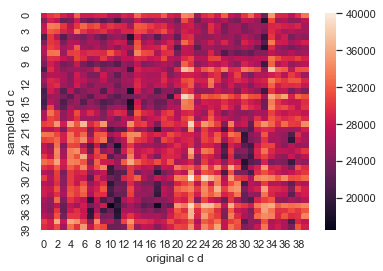

In [319]:
sns.set()
ax = sns.heatmap(abcd_36)
ax.set_xlabel("original c d")
ax.set_ylabel("sampled d c")

#### NOTES:
- when I use the unembedded data, ~~I get a lot of -inf in my estimation~~
- the kernel density estimation needs some parameter tuning.
    - Should I use some other estimator?
- I was considering using some kind of density or mode for comparing one sample against controll and diseased original data.
- ~~Is there a mistake in the KL function~~~
- Is there another more appropriate density comparator?
- One thing I knowtised is that the GMM with more nr of components gives a more complex density estimation, therefore is harder for the kernel density estimator to estimate a sample that came from there.

### Plot UMAP embedding, use control and deciesed cells, plot each patient under the embedding

In [36]:
umap_control = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)
umap_control.fit(get_cells_of_group_without_columns(df_scaled, "control", ["id","group"]))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=10, negative_sample_rate=5, random_state=0,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [37]:
umap_diseased = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)
umap_diseased.fit(get_cells_of_group_without_columns(df_scaled, "diseased", ["id","group"]))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=10, negative_sample_rate=5, random_state=0,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

### Plot embedding of all patient cells of each group

Text(0.5,1,'All control cells')

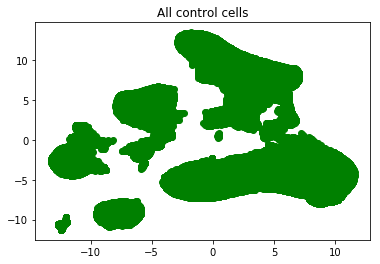

In [22]:
all_control_embeddings = umap_control.transform(get_cells_of_group_without_columns(df_scaled, "control", ["id","group"]))
plt.scatter(all_control_embeddings[:,0], all_control_embeddings[:,1], c="green")
plt.title("All control cells")

Text(0.5,1,'All diseased cells')

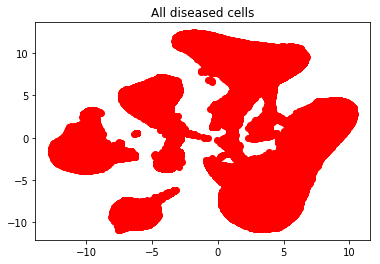

In [17]:
all_diseased_embeddings = umap_diseased.transform(get_cells_of_group_without_columns(df_scaled, "diseased", ["id","group"]))
plt.scatter(all_diseased_embeddings[:,0], all_diseased_embeddings[:,1], c="red")
plt.title("All diseased cells")

### Tranform each patient using its respective group umap embedding

In [18]:
control_UMAP_embedding =  []
for i in range(1,21):
    control_UMAP_embedding/
    .append(umap_control/
            .transform(get_cells_of_patient_without_columns(df_scaled, i, ["id","group"])))

/opt/anaconda2/lib/python2.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda2/lib/python2.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/opt/anaconda2/lib/python2.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda2/lib/python2.7/site-packages/umap/nndescent.

In [19]:
diseased_UMAP_embedding = []
for i in range(21,41):
    diseased_UMAP_embedding/
    .append(umap_diseased/
            .transform(get_cells_of_patient_without_columns(df_scaled, i, ["id","group"])))

In [20]:
np.save("diseased_UMAP_embedding", diseased_UMAP_embedding)
np.save("control_UMAP_embedding", control_UMAP_embedding)

### Plot the embedding

<function matplotlib.pyplot.show>

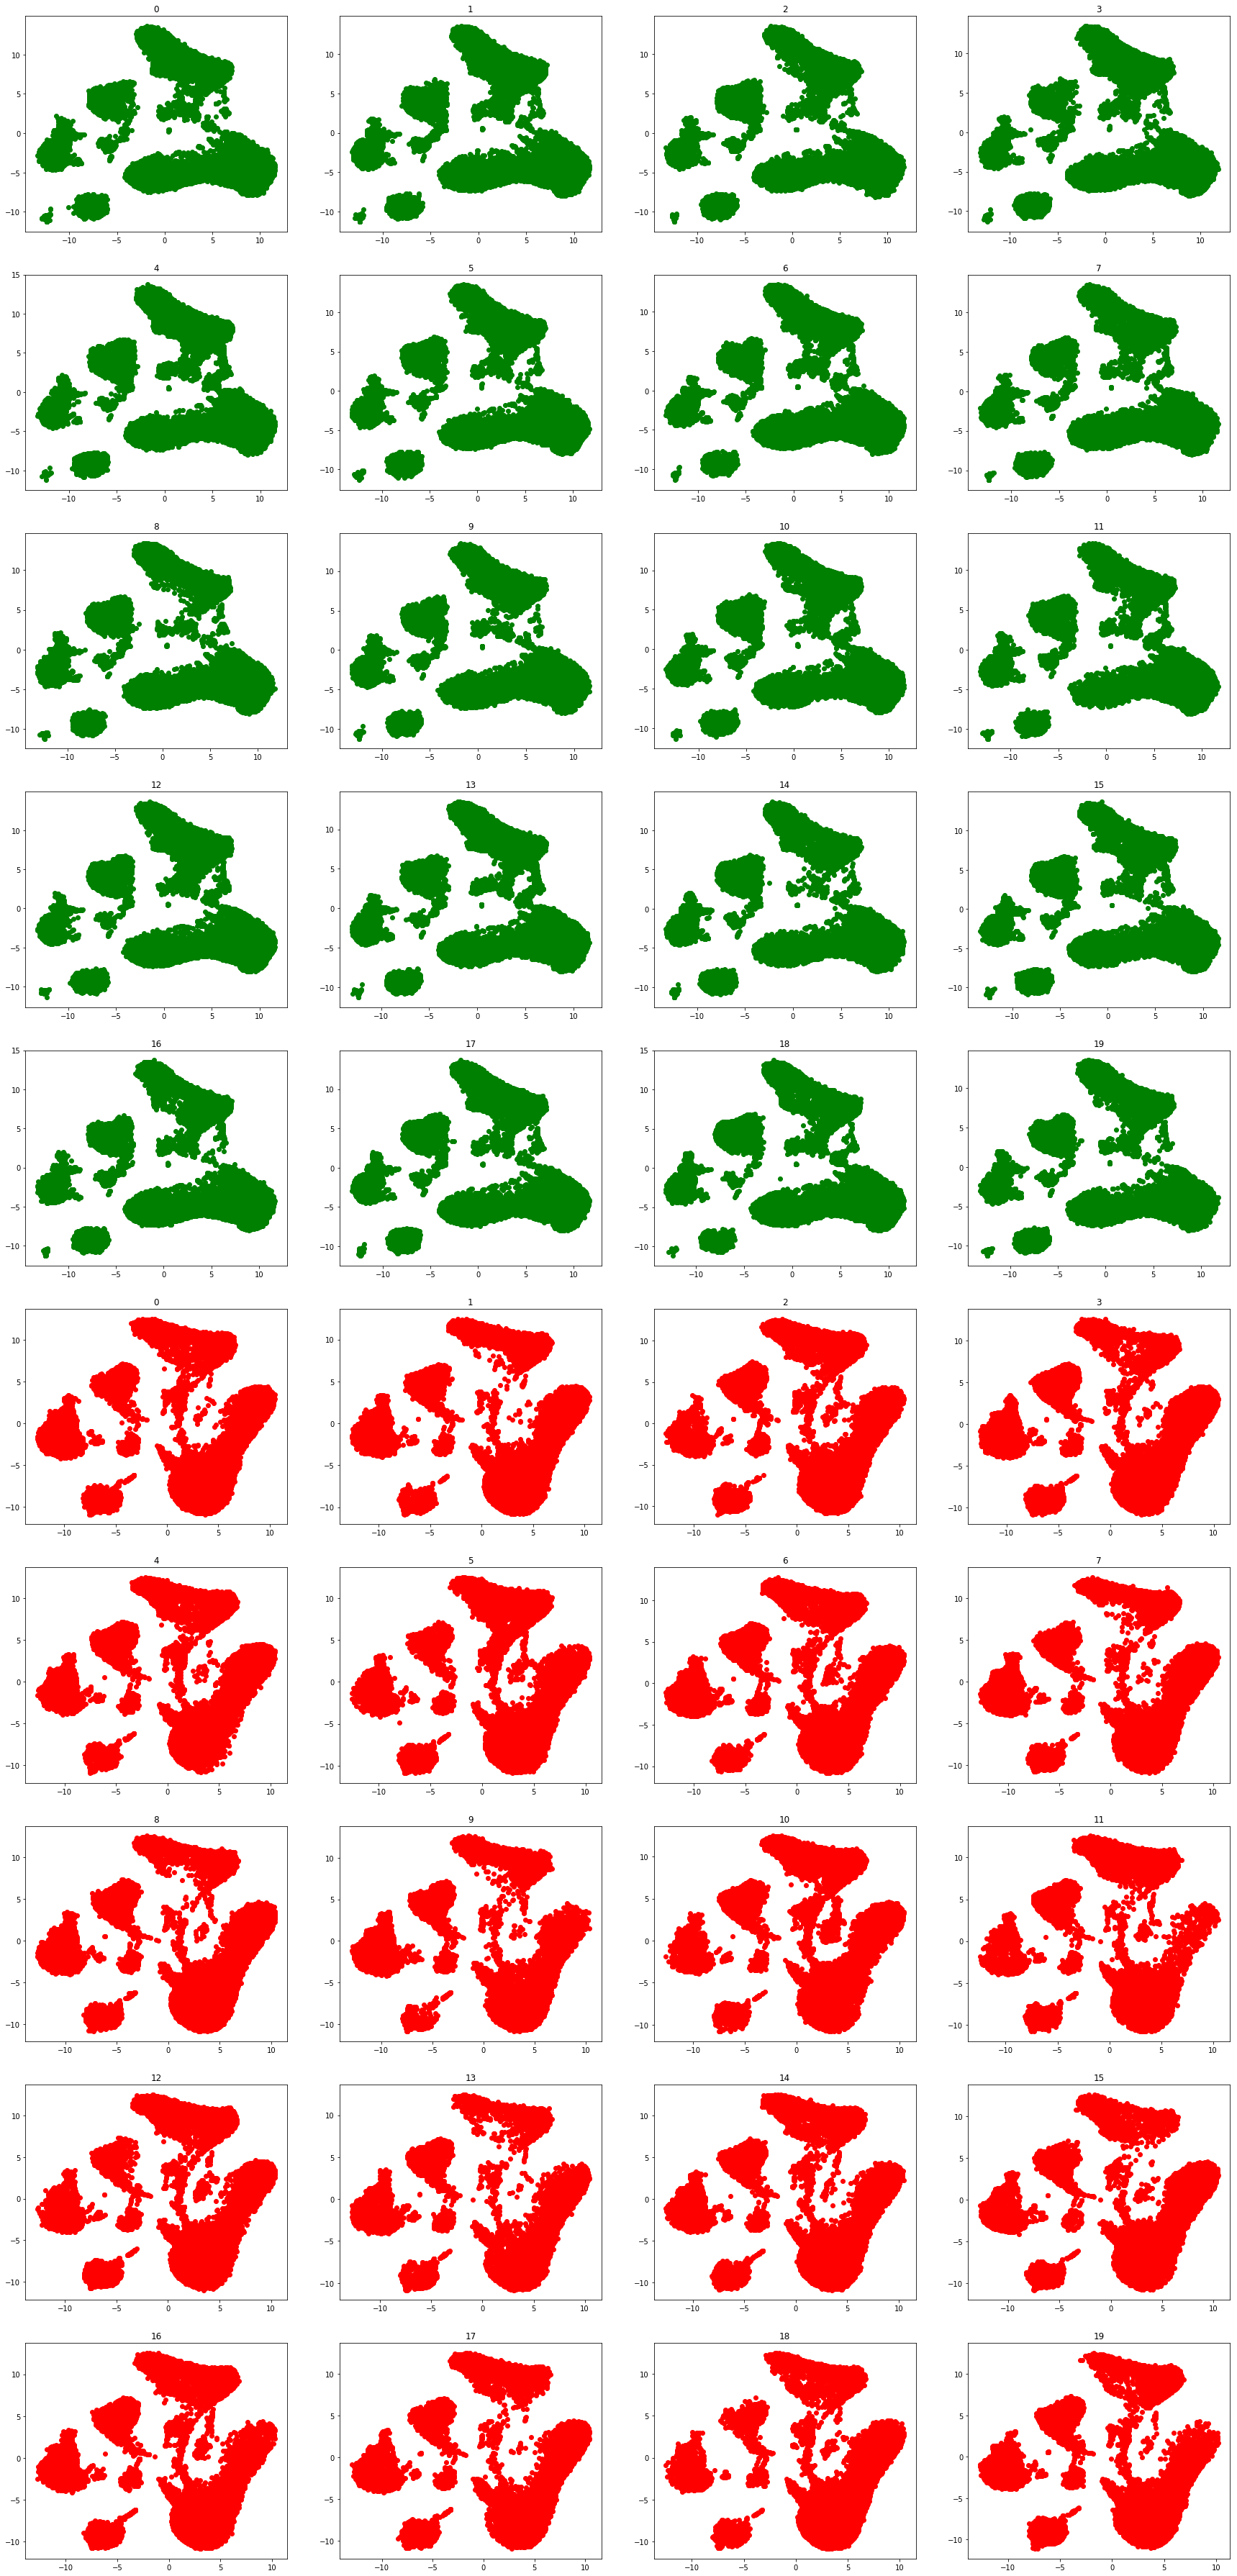

In [21]:
fig, axs = plt.subplots(10,4,figsize = (30,65))
axs = trim_axs(axs, 40)

for id_nr, (ax, res) in enumerate(zip(axs[:20], control_UMAP_embedding)):
    ax.scatter(res[:,0], res[:,1], c="green")
    ax.set_title(id_nr)
for id_nr , (ax, res) in enumerate(zip(axs[20:], diseased_UMAP_embedding)):
    ax.scatter(res[:,0], res[:,1], c="red")
    ax.set_title(id_nr)

plt.show

## Compare embeddings of generated and original patients

#### Compare 
- control sampled and control original
- diseased sampled and diseased original
- diseased sampled and control original
- control sampled and diseased original

##### Load embeddings

In [23]:
original_diseased = np.load('diseased_UMAP_embedding.npy')
original_controls = np.load('control_UMAP_embedding.npy')

##### Sample 20 control and 20 diseased from GMM

In [24]:
sampled_controls = generate_patients(G8s_["control"],sample_size=20000, nr_patients=20)
sampled_diseased = generate_patients(G8s_["diseased"],sample_size=20000, nr_patients=20)

##### Embed the samples using UMAP of the original data

In [25]:
embedded_sampled_controls = []
embedded_sampled_diseased = []
for i in range(20):
    embedded_sampled_controls.append(umap_control.transform(sampled_controls[i]))
    embedded_sampled_diseased.append(umap_diseased.transform(sampled_diseased[i]))

### Plot the sampled embedding

<function matplotlib.pyplot.show>

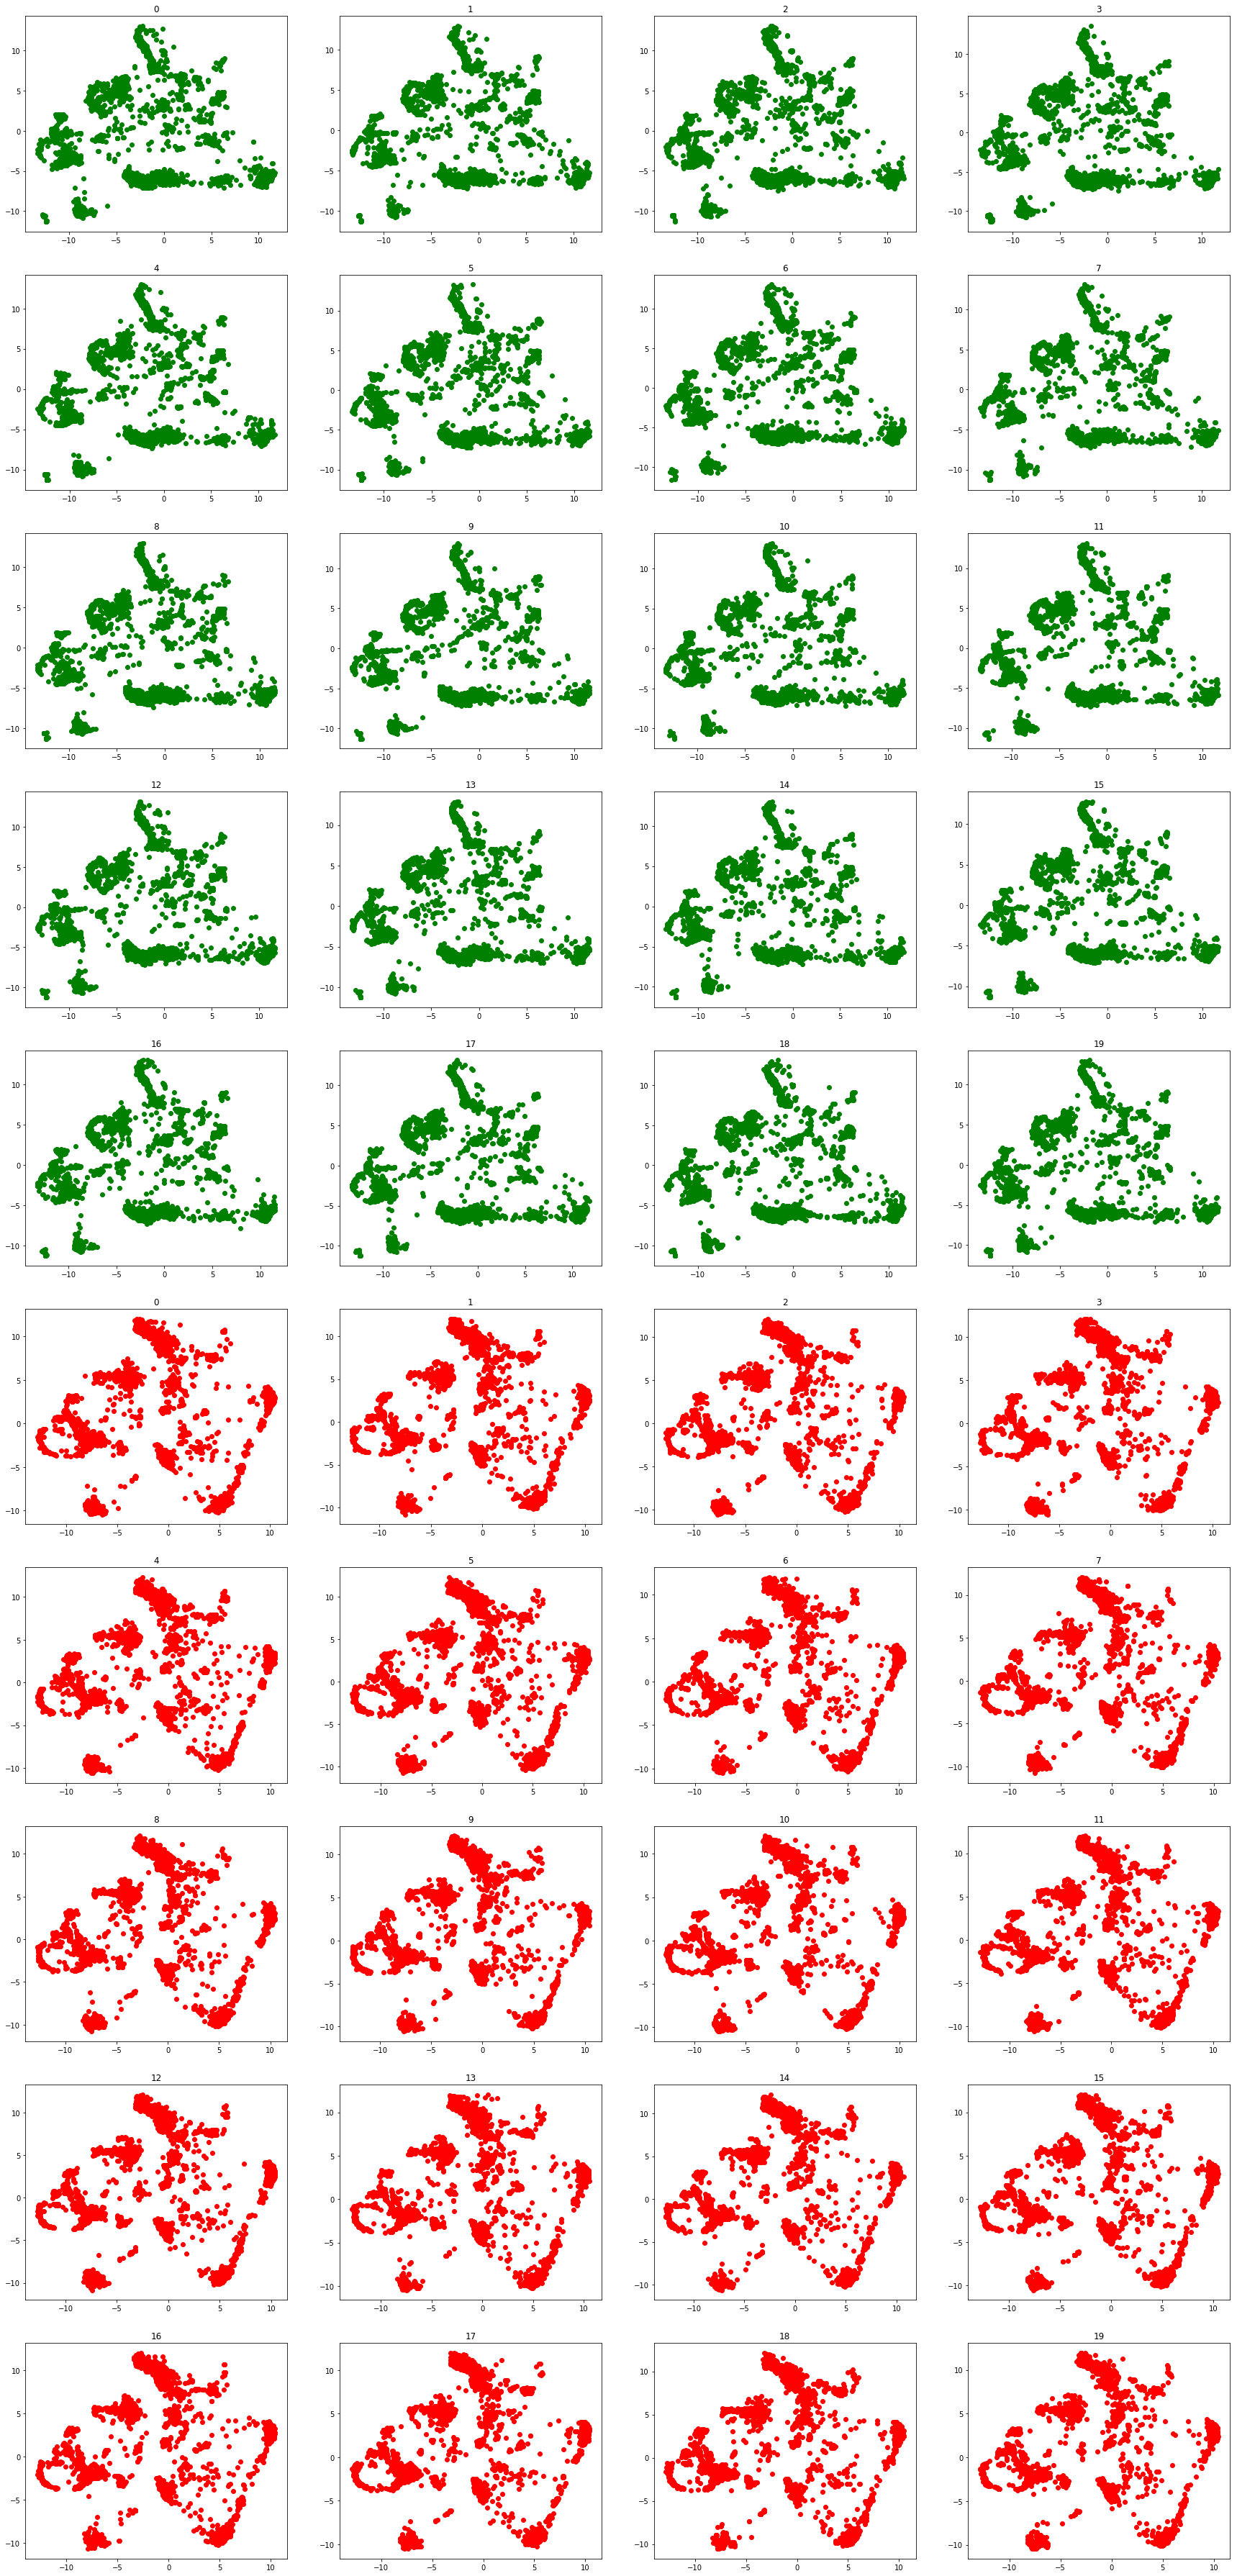

In [26]:
fig, axs = plt.subplots(10,4,figsize = (30,65))
axs = trim_axs(axs, 40)

for id_nr, (ax, res) in enumerate(zip(axs[:20], embedded_sampled_controls)):
    ax.scatter(res[:,0], res[:,1], c="green")
    ax.set_title(id_nr)
for id_nr , (ax, res) in enumerate(zip(axs[20:], embedded_sampled_diseased)):
    ax.scatter(res[:,0], res[:,1], c="red")
    ax.set_title(id_nr)

plt.show

##### Get the KL divergence between each pair of sample and original patient

In [79]:
KL_sum_cc_8 = np.empty((20,20))
KL_sum_dd_8 = np.empty((20,20))
KL_sum_cd_8 = np.empty((20,20))
KL_sum_dc_8 = np.empty((20,20))
for i in range(20):
    for j in range(20):
        KL_sum_cc_8[i,j] = KL_between_two_patients(embedded_sampled_controls[i], original_controls[j])
        KL_sum_dd_8[i,j] = KL_between_two_patients(embedded_sampled_diseased[i], original_diseased[j])
        KL_sum_cd_8[i,j] = KL_between_two_patients(embedded_sampled_diseased[i], original_controls[j])
        KL_sum_dc_8[i,j] = KL_between_two_patients(embedded_sampled_controls[i], original_diseased[j])

### HeatMap

#### NOTES:
- Concatenated the heapmap to get relative view of how each pair match

In [80]:
ab = np.concatenate((KL_sum_cc_8,KL_sum_cd_8),axis=1)
cd = np.concatenate((KL_sum_dc_8,KL_sum_dd_8),axis=1)
abcd = np.concatenate((ab,cd),axis=0)

Text(30.5,0.5,'sampled c d')

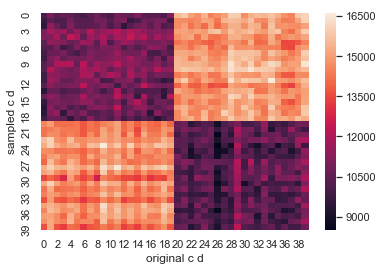

In [81]:
sns.set()
ax = sns.heatmap(abcd)
ax.set_xlabel("original c d")
ax.set_ylabel("sampled c d")

### BoxPlot

In [125]:
def box_plot(data, title):
    fig, ax = plt.subplots(1, len(response), sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(18)
    for i, r in enumerate(response):
        sns.boxplot(data=data[i], ax=ax[i])
        ax[i].set_title(r)
    ax[0].set_ylabel('average KL divergence')
    fig.subplots_adjust(wspace=0)

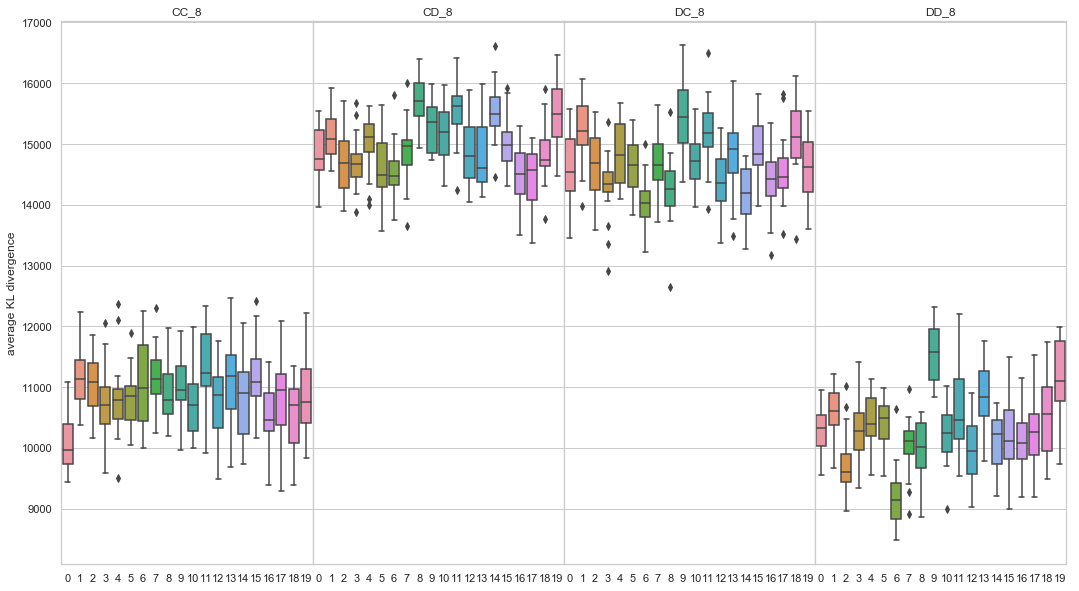

In [126]:
title_8 = ['CC_8', 'CD_8', 'DC_8', 'DD_8']
data_8 = [KL_sum_cc_8, KL_sum_cd_8, KL_sum_dc_8, KL_sum_dd_8]
box_plot(data_8,title_8)

##### Notes:
- with gmm8 the sampled diseased patient and the orginal diseased patient are resonably more similar under KL divergence than the others, as we expect if the density estimation is good.
- 

### KL using embedded data from G36 gmm

In [30]:
g36_sampled_controls = generate_patients(G36s_["control"],sample_size=20000, nr_patients=20)
g36_sampled_diseased = generate_patients(G36s_["diseased"],sample_size=20000, nr_patients=20)

In [38]:
g36_embedded_sampled_controls = []
g36_embedded_sampled_diseased = []
for i in range(20):
    g36_embedded_sampled_controls.append(umap_control.transform(g36_sampled_controls[i]))
    g36_embedded_sampled_diseased.append(umap_diseased.transform(g36_sampled_diseased[i]))

<function matplotlib.pyplot.show>

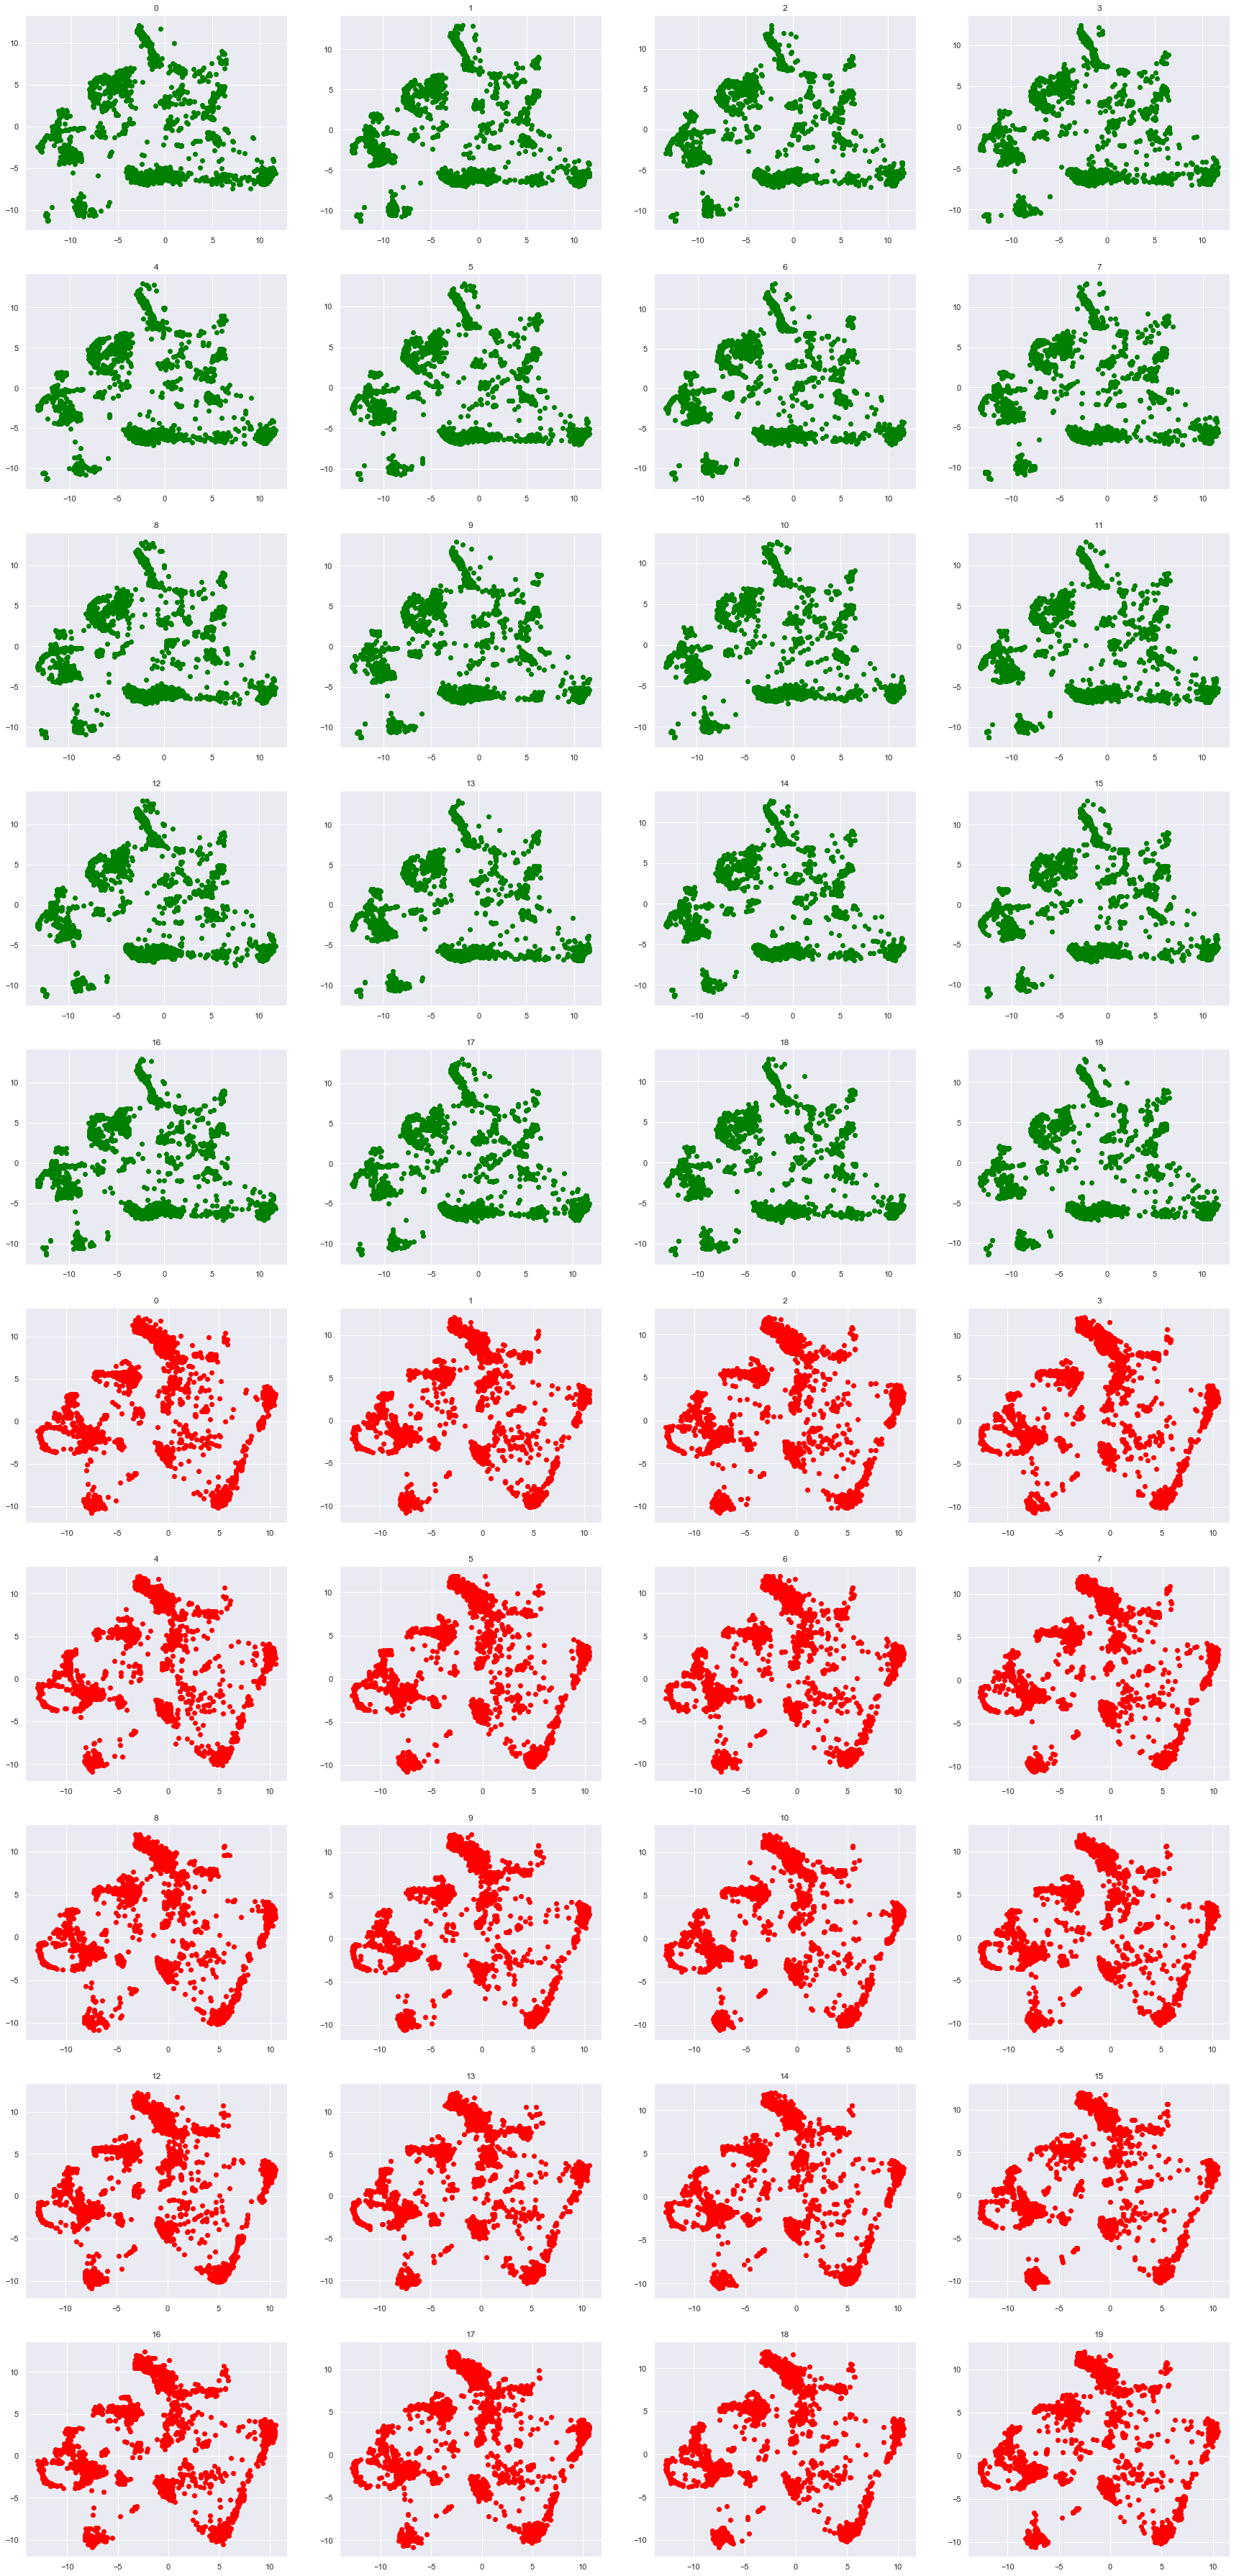

In [39]:
fig, axs = plt.subplots(10,4,figsize = (30,65))
axs = trim_axs(axs, 40)

for id_nr, (ax, res) in enumerate(zip(axs[:20], g36_embedded_sampled_controls)):
    ax.scatter(res[:,0], res[:,1], c="green")
    ax.set_title(id_nr)
for id_nr , (ax, res) in enumerate(zip(axs[20:], g36_embedded_sampled_diseased)):
    ax.scatter(res[:,0], res[:,1], c="red")
    ax.set_title(id_nr)

plt.show

In [40]:
KL_sum_cc_36 = np.empty((20,20))
KL_sum_dd_36 = np.empty((20,20))
KL_sum_cd_36 = np.empty((20,20))
KL_sum_dc_36 = np.empty((20,20))
for i in range(20):
    for j in range(20):
        KL_sum_cc_36[i,j] = KL_between_two_patients(g36_embedded_sampled_controls[i], original_controls[j])
        KL_sum_dd_36[i,j] = KL_between_two_patients(g36_embedded_sampled_diseased[i], original_diseased[j])
        KL_sum_cd_36[i,j] = KL_between_two_patients(g36_embedded_sampled_diseased[i], original_controls[j])
        KL_sum_dc_36[i,j] = KL_between_two_patients(g36_embedded_sampled_controls[i], original_diseased[j])

#### HeatMap

In [41]:
ab_36 = np.concatenate((KL_sum_cc_36,KL_sum_cd_36),axis=1)
cd_36 = np.concatenate((KL_sum_dc_36,KL_sum_dd_36),axis=1)
abcd_36 = np.concatenate((ab_36,cd_36),axis=0)

Text(30.5,0.5,'sampled diseased - control')

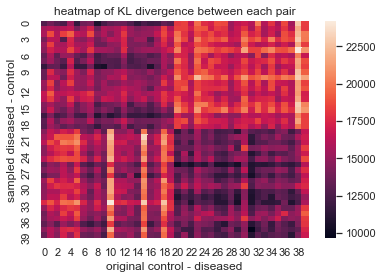

In [42]:
sns.set()
ax = sns.heatmap(abcd_36)
ax.set_title("heatmap of KL divergence between each pair")
ax.set_xlabel("original control - diseased")
ax.set_ylabel("sampled diseased - control")

### BoxPlot

#### boxplot of each sampled patient compared to its group in the original data

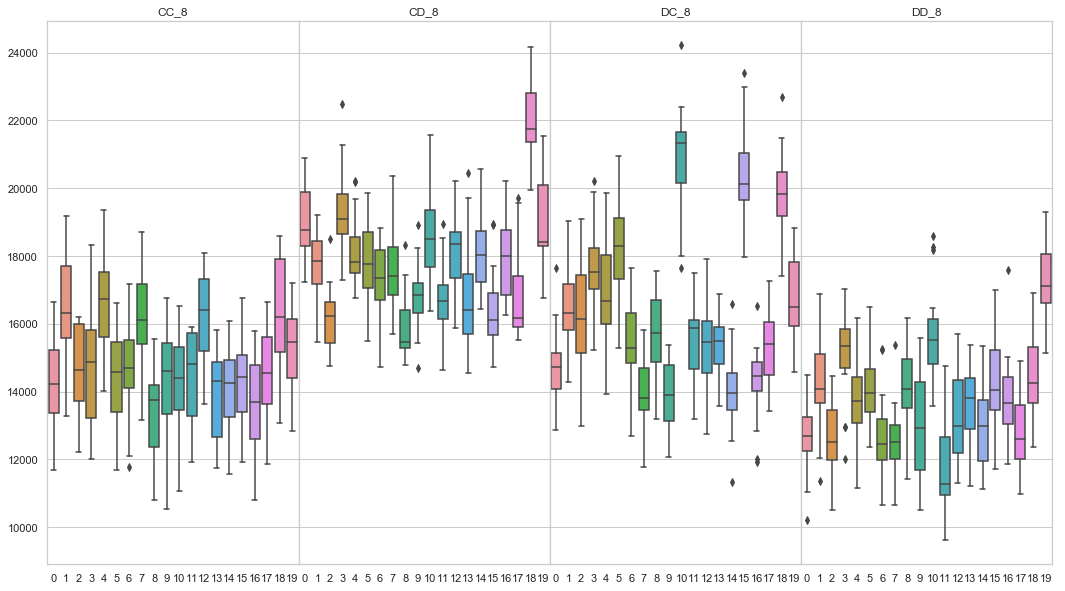

In [122]:
title_36 = ['CC_36', 'CD_36', 'DC_36', 'DD_36']
data_36= [KL_sum_cc_36, KL_sum_cd_36, KL_sum_dc_36, KL_sum_dd_36]
box_plot(data_36,title_36)

## TSNE embedding